# Ecai experiments



In [286]:
from pathlib import Path
import json
import sys
import math
import subprocess
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean
import pandas as pd
from IPython.display import display, HTML
from plotly import graph_objects as go, express as px
import numpy as np

In [287]:
def file_pprint_json(filename):
    with open(filename, 'r') as f:
        array = json.load(f)
    print(json.dumps(array, indent=4, sort_keys=True))

In [288]:
def read_print(filename):
    q = Path(filename)
    with q.open() as f: 
        s = f.readlines()
        #print(s)

In [289]:
def json2array(filename):
    with open(filename, 'r') as f:
        array = json.load(f)
    return array

In [290]:
def pprint_json(array):
    print(json.dumps(array, indent=4, sort_keys=False))

In [291]:
def basecost(clues, constraints):
    if constraints == 1 and clues == 0:
        return 0
    elif constraints > 1 and clues == 0:
        return 20
    else:
        return 20 * clues    

In [292]:
def f(clues, assumptions, constraints):
    c_a = 5
    return basecost(clues, constraints) +  assumptions + c_a * (constraints + clues)

In [293]:
def f_cost(assumptions, clue, cost):
    n_assumptions = len(assumptions)
    n_clues = 0
    n_constraints = 0
    n_implicit = 0

    if clue in ["Combination of logigram constraints"]:
        n_clues = 0
        n_constraints = 2
    elif clue in ["Bijectivity", "Transitivity constraint"]:
        n_clues = 0
        n_constraints = 1
    else:
        n_clues = 1
    
    n_implicit = max(0, cost - n_assumptions - basecost(n_clues, n_constraints) - n_clues)

    updated_cost = f(n_clues, n_assumptions, n_implicit)

    return updated_cost

In [294]:
def update_cost_explanations(explanation_array):
    s_nested_explanation = "nested_explanations"
    s_reason_sequence = "reason_sequence"

    for expl in explanation_array:
        #if "Solution!" in expl["clue"]:
        #    continue
        expl["cost"] = f_cost(assumptions = expl["assumptions"], clue = expl["clue"], cost = int(expl["cost"]) )

        if s_nested_explanation in expl:
            for n_expl in expl[s_nested_explanation]:
                if s_reason_sequence in n_expl:
                    for r_expl in n_expl[s_reason_sequence]:
                        r_expl["cost"] = f_cost(assumptions = r_expl["assumptions"], clue = r_expl["clue"], cost = int(r_expl["cost"]) )


    return explanation_array

In [295]:
def filter_nested_explanations(explanation_array):
    '''Filters the explanations with nested explanations and for every nested explanations
    removes last step from reason_sequence and if nested_explanation is only 1 step it is removed
    as well.
    Remove also last step from nested explanation list.
    '''
    s_nested_explanation = "nested_explanations"
    # s_reason_sequence = "reason_sequence"
    # data_dict = {}
    
    # take explanations only with nested explanations
    expl_w_nested = [expl for expl in explanation_array if s_nested_explanation in expl and len(expl[s_nested_explanation]) > 0]
    
    return expl_w_nested

In [296]:
def build_statistics(explanation_array):
    s_nested_explanation = "nested_explanations"
    s_reason_sequence = "reason_sequence"
    
    stat_dict = {
        'cost' : [],  # explanation cost
        'n_nested_expl' : [], # number of nested explanations generated
        'n_reason_seq' : [], # list of steps in reason sequence for every nested explanation
        'n_avg_reason_seq': [], # avg number of reason sequences in nested explanation
        'n_avg_nested': 0,
        'cost_reason_seq' : [], # list of costs in reason sequence for every nested explanation
        'avg_cost_reason_seq' : [], # list of avg costs of reason sequence for every nested explanation
        'avg_cost_reason' : [],
        'diff_cost_avg_reason': [], # difference cost 
        'n_reason_seq_expl': 0, # total number of seq explanations
        'avg_facts_all_reason_seq' : 0,  # avg facts used in seq explanations
        'avg_facts_clues_reason_seq' : 0,  #  avg nr clues used in seq explanations
        'avg_facts_trans_reason_seq' : 0,  #  avg nr trans used in seq explanations
        'avg_facts_bij_reason_seq' : 0,  #  avg nr bij used in seq explanations
        'avg_0_facts_clue_reason_seq' : 0,   # avg % 0 facts used with clue in seq explanations       
        'avg_1_facts_clue_reason_seq' : 0,  # avg % 1 facts used with clue in seq explanations       
        'avg_2_facts_clue_reason_seq' : 0,  # avg % 2 facts used with clue in seq explanations       
        'avg_more_facts_clue_reason_seq' : 0,  # avg % more than 2 facts used with clue in seq explanations       
        'facts_all_reason_seq' : [],  # nr facts 
        'facts_clues_reason_seq' : [],  # number of facts every time a seq explanation is a clue
        'facts_trans_reason_seq' : [],  # number of facts every times  seq explanation is a transitivity
        'facts_bij_reason_seq' : [],  # number of facts every times  seq explanation is a bij
        '0_facts_clue_reason_seq' : [],  # 1 if  0 facts used together with clue ever time seq explanation is a clue
        '1_facts_clue_reason_seq' : [],  #  1 if  1 facts used together with clue ever time seq explanation is a clue 
        '2_facts_clue_reason_seq' : [],  #  1 if  2 facts used together with clue ever time seq explanation is a clue 
        'more_facts_clue_reason_seq' : [],  #  1 if  more than 2 facts used together with clue ever time seq explanation is a clue 
        'avg_cost' : []
    }
    
    # for every explanation in explanation sequence
    for expl in explanation_array:
        # initialisation lists
        l_reason_seq_len = []
        l_avg_cost_reason_seq = []
        l_cost_reason_seq = []
        # statistics for cost and sequence 
        # for every nested explanation in lsit of nested explanations
        for n_expl in expl[s_nested_explanation]:
            l_n_cost_reason_seq = []
            
            # for every explanation in nested explanation
            for r_expl in n_expl[s_reason_sequence]:
                l_n_cost_reason_seq.append(r_expl["cost"])
            #print(l_n_cost_reason_seq)
            avg_cost_reason_seq = mean(l_n_cost_reason_seq)
            l_avg_cost_reason_seq.append(avg_cost_reason_seq)
            l_cost_reason_seq.append(l_n_cost_reason_seq)
            l_reason_seq_len.append(len(n_expl[s_reason_sequence]))
        
        # filling the statisticsdictionary
        stat_dict['cost'].append(expl['cost'])
        stat_dict['n_nested_expl'].append(len(expl[s_nested_explanation]))
        stat_dict['n_reason_seq'].append(l_reason_seq_len)
        #print(l_reason_seq_len, expl)
        stat_dict['n_avg_reason_seq'].append(mean(l_reason_seq_len))
        stat_dict['cost_reason_seq'].append(l_cost_reason_seq)
        stat_dict['avg_cost_reason_seq'].append(l_avg_cost_reason_seq)
        stat_dict['avg_cost_reason'].append(mean(l_avg_cost_reason_seq))        
        
        # statistics for cost and sequence 
        # for every nested explanation in lsit of nested explanations
        for n_expl in expl[s_nested_explanation]:
            # for every explanation in nested explanation
            for r_expl in n_expl[s_reason_sequence]:
                n_assumptions = len(r_expl['assumptions'])
                facts_clues = 0
                facts_trans = 0
                facts_bij = 0
                facts_0_clues = 0
                facts_1_clues = 0
                facts_2_clues = 0
                facts_more_clues = 0

                if r_expl["clue"] not in ["Combination of logigram constraints", "Bijectivity", "Transitivity constraint"]:
                    facts_clues = n_assumptions
                    
                    if n_assumptions == 0:
                        facts_0_clues = 1
                    elif n_assumptions == 1:
                        facts_1_clues = 1
                    elif n_assumptions == 2:
                        facts_2_clues = 1
                    elif n_assumptions > 2:
                        facts_more_clues = 1

                    stat_dict['facts_clues_reason_seq'].append(facts_clues)
                    stat_dict['0_facts_clue_reason_seq'].append(facts_0_clues)
                    stat_dict['1_facts_clue_reason_seq'].append(facts_1_clues)
                    stat_dict['2_facts_clue_reason_seq'].append(facts_2_clues)
                    stat_dict['more_facts_clue_reason_seq'].append(facts_more_clues)
                    
                elif r_expl["clue"] == "Bijectivity":
                    facts_bij = n_assumptions
                    stat_dict['facts_bij_reason_seq'].append(facts_bij)
                elif r_expl["clue"] == "Transitivity constraint":
                    facts_trans = n_assumptions
                    stat_dict['facts_trans_reason_seq'].append(facts_trans)
                
                # filling the dict
                stat_dict['n_reason_seq_expl'] += 1
                stat_dict['facts_all_reason_seq'].append(len(r_expl['assumptions']))                

    stat_dict['avg_cost'] = mean(stat_dict['cost'])
    if len(stat_dict['facts_all_reason_seq']) > 0:
        stat_dict['avg_facts_all_reason_seq'] = mean(stat_dict['facts_all_reason_seq'])
    else:
        stat_dict['avg_facts_all_reason_seq'] = None
    if len(stat_dict['facts_clues_reason_seq']) > 0:
        stat_dict['avg_facts_clues_reason_seq'] = mean(stat_dict['facts_clues_reason_seq'])
    else:
        stat_dict['avg_facts_clues_reason_seq'] = None
    if len(stat_dict['facts_trans_reason_seq']) > 0:
        stat_dict['avg_facts_trans_reason_seq'] = mean(stat_dict['facts_trans_reason_seq'])
    else:
        stat_dict['avg_facts_trans_reason_seq'] = None
    if len(stat_dict['facts_bij_reason_seq']) > 0:
        stat_dict['avg_facts_bij_reason_seq'] = mean(stat_dict['facts_bij_reason_seq'])
    else:
        stat_dict['avg_facts_bij_reason_seq'] = None
    if len(stat_dict['0_facts_clue_reason_seq']) > 0:
        stat_dict['avg_0_facts_clue_reason_seq'] = mean(stat_dict['0_facts_clue_reason_seq'])
    else:
        stat_dict['avg_0_facts_clue_reason_seq'] = None
    if len(stat_dict['1_facts_clue_reason_seq']) > 0:
        stat_dict['avg_1_facts_clue_reason_seq'] = mean(stat_dict['1_facts_clue_reason_seq'])
    else:
        stat_dict['avg_1_facts_clue_reason_seq'] = None
    if len(stat_dict['2_facts_clue_reason_seq']) > 0:
        stat_dict['avg_2_facts_clue_reason_seq'] = mean(stat_dict['2_facts_clue_reason_seq'])
    else:
        stat_dict['avg_2_facts_clue_reason_seq'] = None
    if len(stat_dict['more_facts_clue_reason_seq']) > 0:
        stat_dict['avg_more_facts_clue_reason_seq'] = mean(stat_dict['more_facts_clue_reason_seq'])
    else:
        stat_dict['avg_more_facts_clue_reason_seq'] = None 
    stat_dict['n_avg_nested'] = round(mean(stat_dict['n_avg_reason_seq']), 2)
    stat_dict['avg_cost_reason'] = round(mean(stat_dict['avg_cost_reason']), 2)
    #print(stat_dict['n_avg_reason_seq'])
    return stat_dict

In [297]:
def puzzle_statistics(explanation_array):
    # puzzle statistics dictionary
    puzzle_dict = {
        'steps': len(explanation_array) - 1,
        'costs': [], # ok
        'avg_cost': 0, 
        'nested_steps': 0, # ok
        'cost_nested': [], # ok
        'avg_cost_nested': 0,#ok
        '% nested': 0,#ok
        'nested-derived': [],
        'avg_nested-derived':0
        #'$\bar{nested-derived}}$': 0, # % = |nested explanation|/|derived facts|
    }
    # strings
    s_nested_explanation = "nested_explanations"
    
    # for every explanation
    for expl in explanation_array:

        puzzle_dict['costs'].append(expl["cost"])
        if s_nested_explanation in expl:
            #expl["nested_explanations"] = expl["nested_explanations"][:-1]
            if len(expl["nested_explanations"]) > 0:
                puzzle_dict['nested_steps'] += 1
                puzzle_dict['cost_nested'].append(expl["cost"])
                puzzle_dict['nested-derived'].append( len(expl["nested_explanations"])/len(expl["derivations"]) )
            
    
    puzzle_dict['avg_cost'] = mean(puzzle_dict['costs'])
    puzzle_dict['avg_cost_nested'] = mean(puzzle_dict['cost_nested'])
    puzzle_dict['% nested'] = puzzle_dict['nested_steps']/puzzle_dict['steps']
    puzzle_dict['avg_nested-derived'] = mean(puzzle_dict['nested-derived'])
    
    return puzzle_dict

In [298]:
def debug(text):
    verbose = True
    if verbose:
        if(type(text) is list):
            print(text)
        elif(type(text) is dict):
            pprint_json(text)
        else:
            print(text)

In [299]:
def clean_nested_explanation(explanation_array):
    s_nested_explanation = "nested_explanations"
    for expl in explanation_array:
        if s_nested_explanation in expl:
            expl[s_nested_explanation] = expl[s_nested_explanation][:-1]
    explanation_array = explanation_array[:-1]
    return explanation_array

In [331]:
'''
dict['filename'] = {costs, clue, assumptions, derivations}

    data = {}
    
    data['costs'] = []
    data['clue'] = []
    data['assumptions'] =  []
    data['derivations'] =  []

    stats['cost'] = {}
    
    stats['cost']['costs_counter']
    stats['cost']['total_cost']
    stats['cost']['avg_cost']
    
    stats['clues'] = {}
    stats['clues']['clues_counter']
    stats['clues']['clues_successive_count']
'''
results = "./output"
p = Path(results)

ignored_files = ['p12.output.json', 'p13.output.json']
files = [x for x in p.iterdir() if x.is_file() and x.name not in ignored_files]

json_file = list(filter(lambda x: 'output.json' in x.name , files) )
#problems = list(filter(lambda x: 'nielspasta' in x.name or 'p5' in x.name , json_file))
file_paths = list(map(lambda f: f.absolute().as_posix(), json_file))
#print(file_paths)

#statistics = {}
nested_data = {}

stats = {}
stats_puzzle = {}
puzzle_explanation_array = {}

for i, fp in enumerate(file_paths):
    problem_name = json_file[i].name
    json_array = json2array(fp)
    explanation_array = clean_nested_explanation(json_array) 
    # update costs of explanations according to new fucntion
    explanation_array = update_cost_explanations(explanation_array)
    
    puzzle_explanation_array[problem_name] = explanation_array
    
    # build puzzle statistics
    stats_puzzle[problem_name] = puzzle_statistics(explanation_array)
    # debug(stats_puzzle[problem_name])
    # filter only steps with nested explanations
    nested_data[problem_name] =  filter_nested_explanations(explanation_array)
    # statistics on steps with nested explanations
    stats[problem_name] = build_statistics(nested_data[problem_name])   

d_facts = []
for problem_name in stats:
    d_facts.append(
        {
            'p': problem_name,
            '$\\bar{|fact_{all}|}$': round(stats[problem_name]['avg_facts_all_reason_seq'], 2) if stats[problem_name]['avg_facts_all_reason_seq']!= None else None,
            '$\\bar{|fact_{Clue}|}$': round(stats[problem_name]['avg_facts_clues_reason_seq'],2) if stats[problem_name]['avg_facts_clues_reason_seq']!= None else None,
            '$\\bar{|fact_{Tr}|}$': round(stats[problem_name]['avg_facts_trans_reason_seq'],2) if stats[problem_name]['avg_facts_trans_reason_seq']!= None else None,
            '$\\bar{|fact_{B}|}$': round(stats[problem_name]['avg_facts_bij_reason_seq'],2) if stats[problem_name]['avg_facts_bij_reason_seq']!= None else None,
            '0 facts': str(round(stats[problem_name]['avg_0_facts_clue_reason_seq'] * 100, 0)) + "%",
            '1 facts': str(round(stats[problem_name]['avg_1_facts_clue_reason_seq'] * 100, 0)) + "%",
            '2 facts': str(round(stats[problem_name]['avg_2_facts_clue_reason_seq']  * 100, 0)) + "%",
            '>2 facts': str(round(stats[problem_name]['avg_more_facts_clue_reason_seq']  * 100, 0)) + "%"
        }
    )

d_puzzle = []
for problem_name in stats_puzzle:
    stat = stats_puzzle[problem_name]
    d_puzzle.append(
        {
            'p': problem_name,
            '| steps |' : stat['steps'], # number of steps
            '$\% steps_{nested}$': str(round(stat['% nested']* 100, 0)) + "%", # % of steps with nested explanations
            '$\\bar{cost}$' : round(stat['avg_cost'],2), # avg cost
            '$\\bar{cost_{nested}}$': round(stat['avg_cost_nested'], 2), # avg cost of step with nested explanation
            '$\\bar{cost_{expl}}$': round(stats[problem_name]['avg_cost_reason'],2), # avg cost of reasons sequence in nested explanation 
            '$\\bar{nested-derived}$': str(round(stat['avg_nested-derived']* 100, 0)) + "%", # % = |nested explanation|/|derived facts|
            '$\\bar{|expl_{nested}|}$': round(mean(stats[problem_name]['n_avg_reason_seq']),2) # average length of reason sequence in nested explanation
        }
    )  

    
stats_df = pd.DataFrame(d_facts)
#print(stats_df)
stats_puzzle_df = pd.DataFrame(d_puzzle)
#print(stats_puzzle_df)

display(HTML(stats_df.to_html()))
display(HTML(stats_puzzle_df.to_html()))
#print(stats_df.to_latex())
#print(stats_puzzle_df.to_latex())


#for problem_name in stats:
#    debug(explanation_array)
#    debug(nested_data[problem_name])
#    debug(stats[problem_name])
    

    #if i == 0:
    #    print(stats[problem_name])
    #build_statistics(data[problem_name])
    # print(problem_name)
    # pprint_json(data[problem_name])
#    statistics[problem_name] = build_statistics(data[problem_name])


,p,$\bar{|fact_{all}|}$,$\bar{|fact_{Clue}|}$,$\bar{|fact_{Tr}|}$,$\bar{|fact_{B}|}$,0 facts,1 facts,2 facts,>2 facts
0,p20.output.json,2.07,3.40,2.0,1.0,0%,0%,30.0%,70.0%
1,p5-split.output.json,2.08,4.11,2.0,1.0,0%,0%,22.0%,78.0%
2,p93.output.json,2.23,3.86,2.0,1.0,0%,0%,14.0%,86.0%
3,p25.output.json,2.14,4.00,2.0,1.0,0%,5.0%,24.0%,71.0%
4,p17.output.json,2.50,4.00,NaN,1.0,0%,0%,0%,100%
5,p18.output.json,2.04,4.10,2.0,1.0,0%,0%,0%,100%
6,p16.output.json,1.98,3.05,2.0,1.0,0%,16.0%,32.0%,53.0%
7,p19.output.json,2.18,2.83,NaN,1.4,0%,17.0%,25.0%,58.0%
8,nielspasta-split-nested.output.json,2.33,3.12,2.0,2.0,0%,0%,25.0%,75.0%


,p,| steps |,$\% steps_{nested}$,$\bar{cost}$,$\bar{cost_{nested}}$,$\bar{cost_{expl}}$,$\bar{nested-derived}$,$\bar{|expl_{nested}|}$
0,p20.output.json,115,3.0%,10.12,36.25,15.62,100.0%,3.69
1,p5-split.output.json,106,7.0%,11.47,37.29,15.92,100.0%,4.29
2,p93.output.json,111,3.0%,11.00,34.67,21.31,100.0%,2.92
3,p25.output.json,108,6.0%,10.82,44.17,14.59,100.0%,7.53
4,p17.output.json,114,2.0%,10.37,41.00,22.50,100.0%,2.00
5,p18.output.json,110,5.0%,10.36,38.60,11.62,100.0%,8.15
6,p16.output.json,120,12.0%,12.21,36.86,17.32,100.0%,3.00
7,p19.output.json,120,5.0%,10.95,40.17,23.20,100.0%,2.78
8,nielspasta-split-nested.output.json,81,9.0%,12.94,39.57,17.08,90.0%,3.86


In [332]:
def plot_puzzle(explanations,stats, puzzlename):
    my_puzzle_stats = stats[puzzlename]
    costs_puzzle = [0] + my_puzzle_stats['costs']
    np_steps = np.linspace(0,len(costs_puzzle) - 1, len(costs_puzzle) )
    puzzle_nested_expl_steps = []
    puzzle_nested_expl_cost = []

    for i, expl in enumerate(explanations[puzzlename]):
        if s_nested_explanation in expl:
            puzzle_nested_expl_steps.append(i+1)
            puzzle_nested_expl_cost.append(costs_puzzle[i+1])
    
    plt.plot(np_steps, costs_puzzle)
    plt.scatter(puzzle_nested_expl_steps, puzzle_nested_expl_cost)
    plt.ylabel('some numbers')
    plt.xlabel('some numbers')
    plt.show()

def plotly_puzzle(explanations,stats, puzzlename):
    my_puzzle_stats = stats[puzzlename]
    costs_puzzle = [0] + my_puzzle_stats['costs']
    np_steps = np.linspace(0,len(costs_puzzle) - 1, len(costs_puzzle) )
    puzzle_nested_expl_steps = []
    puzzle_nested_expl_cost = []

    for i, expl in enumerate(explanations[puzzlename]):
        if s_nested_explanation in expl:
            puzzle_nested_expl_steps.append(i+1)
            puzzle_nested_expl_cost.append(costs_puzzle[i+1])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,len(costs_pasta), len(costs_pasta)+1), y=costs_pasta,
                        mode='lines',
                        name='cost'))
    fig.add_trace(go.Scatter(x=nested_expl_steps, y=nested_expl_cost,
                        mode='markers', name='complex steps'))
    fig.show()

#df = px.data.gapminder().query("country=='Canada'")


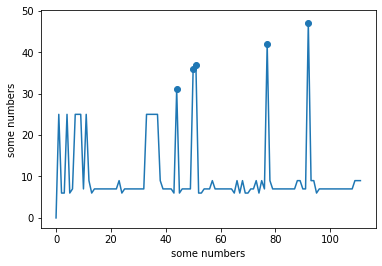

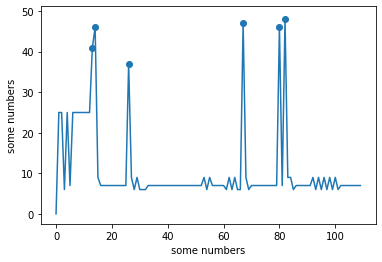

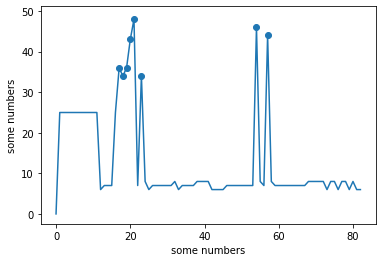

In [338]:
p18 ='p18.output.json'
plot_puzzle(puzzle_explanation_array, stats_puzzle, p18)
p25 = 'p25.output.json'
plot_puzzle(puzzle_explanation_array, stats_puzzle, p25)
pasta = 'nielspasta-split-nested.output.json'
plot_puzzle(puzzle_explanation_array, stats_puzzle, pasta)